In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

# folder with E0.csv ... E7.csv
DATA_PATH = Path('/home/mann-gandhi/Documents/GitHub-Repositories/Arsenal/data')

# Columns you want (canonical names)
KEEP_COLS = [
    'Div','Date','Time','HomeTeam','AwayTeam',
    'FTHG','FTAG','FTR','HTHG','HTAG','HTR',
    'Attendance','Referee','HS','AS','HST','AST',
    'HHW','AHW','HC','AC','HF','AF','HFKC','AFKC','HO','AO',
    'HY','AY','HR','AR','HBP','ABP',
    'League'  # we'll add this
]

# Some files use alternative names → normalize to canonical names
RENAME_MAP = {
    'HG': 'FTHG',     # Full Time Home Goals
    'AG': 'FTAG',     # Full Time Away Goals
    'Res': 'FTR',     # Full Time Result
}

TEXT_COLS = {'Div','Date','Time','HomeTeam','AwayTeam','FTR','HTR','Referee','League'}

def load_one(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, low_memory=False, encoding='utf-8')

    # standardize column names where alternates appear
    present_renames = {k: v for k, v in RENAME_MAP.items() if k in df.columns}
    if present_renames:
        df = df.rename(columns=present_renames)

    # add League from filename (E0.csv -> E0)
    m = re.match(r'(E\d+)\.csv$', path.name)
    df['League'] = m.group(1) if m else path.stem

    # parse dates (dd/mm/yy) and times if present
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    if 'Time' in df.columns:
        # be forgiving about format; keep as time
        t = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce')
        df['Time'] = t.dt.time

    # keep ONLY the requested columns that exist in this file
    cols_here = [c for c in KEEP_COLS if c in df.columns]
    df = df[cols_here]

    # numeric coercion for stats/integers; leave text columns alone
    for c in df.columns:
        if c not in TEXT_COLS:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    return df

# ---- Load and merge ----
csv_files = sorted(p for p in DATA_PATH.glob('E1.csv') if p.is_file()) # change E0 to E* for all past 7 seasons data, 
                                                                        # for a range use E[0-3] to analyze multiple seasons
frames = [load_one(p) for p in csv_files]
combined_df = pd.concat(frames, ignore_index=True, sort=False)

print("Loaded files:", [p.name for p in csv_files])
print("Combined shape:", combined_df.shape)
combined_df.head(5)


Loaded files: ['E1.csv']
Combined shape: (380, 25)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AST,HC,AC,HF,AF,HY,AY,HR,AR,League
0,E0,2024-08-16,20:00:00,Man United,Fulham,1,0,H,0,0,...,2,7,8,12,10,2,3,0,0,E1
1,E0,2024-08-17,12:30:00,Ipswich,Liverpool,0,2,A,0,0,...,5,2,10,9,18,3,1,0,0,E1
2,E0,2024-08-17,15:00:00,Arsenal,Wolves,2,0,H,1,0,...,3,8,2,17,14,2,2,0,0,E1
3,E0,2024-08-17,15:00:00,Everton,Brighton,0,3,A,0,1,...,5,1,5,8,8,1,1,1,0,E1
4,E0,2024-08-17,15:00:00,Newcastle,Southampton,1,0,H,1,0,...,4,3,12,15,16,2,4,1,0,E1


In [36]:
import numpy as np

df = combined_df.copy()

# Ensure totals exist (match-level)
df['TotalGoals'] = df[['FTHG','FTAG']].sum(axis=1)

# Helper mappings to build per-team rows
home_cols = {
    'Team':'HomeTeam', 'Opp':'AwayTeam',
    'GF':'FTHG', 'GA':'FTAG',
    'Shots':'HS', 'SOT':'HST',
    'Corners':'HC', 'Fouls':'HF', 'Offsides':'HO',
    'Yellows':'HY', 'Reds':'HR', 'BookingsPts':'HBP',
}
away_cols = {
    'Team':'AwayTeam', 'Opp':'HomeTeam',
    'GF':'FTAG', 'GA':'FTHG',
    'Shots':'AS', 'SOT':'AST',
    'Corners':'AC', 'Fouls':'AF', 'Offsides':'AO',
    'Yellows':'AY', 'Reds':'AR', 'BookingsPts':'ABP',
}

def _num_series_or_na(d: pd.DataFrame, colname: str, index_like) -> pd.Series:
    """Return numeric series for d[colname] or a NA-filled series if missing."""
    if colname in d.columns:
        return pd.to_numeric(d[colname], errors='coerce')
    # Create a nullable float series of NA if column is absent in this CSV
    return pd.Series(pd.NA, index=index_like, dtype="Float64")

def side_frame(d: pd.DataFrame, mapping: dict, is_home: bool) -> pd.DataFrame:
    idx = d.index
    out = pd.DataFrame({
        'League': d['League'],
        'Div': d['Div'] if 'Div' in d.columns else d['League'],
        'Date': d['Date'],
        'Time': d['Time'] if 'Time' in d.columns else pd.NaT,
        'Team': d[mapping['Team']],
        'Opponent': d[mapping['Opp']],
        'Venue': 'H' if is_home else 'A',
        'GF': _num_series_or_na(d, mapping['GF'], idx),
        'GA': _num_series_or_na(d, mapping['GA'], idx),
        'Shots': _num_series_or_na(d, mapping['Shots'], idx),
        'SOT': _num_series_or_na(d, mapping['SOT'], idx),
        'Corners': _num_series_or_na(d, mapping['Corners'], idx),
        'Fouls': _num_series_or_na(d, mapping['Fouls'], idx),
        'Offsides': _num_series_or_na(d, mapping['Offsides'], idx),
        'Yellows': _num_series_or_na(d, mapping['Yellows'], idx),
        'Reds': _num_series_or_na(d, mapping['Reds'], idx),
        'BookingsPts': _num_series_or_na(d, mapping['BookingsPts'], idx),
        'Attendance': _num_series_or_na(d, 'Attendance', idx) if is_home else pd.Series(pd.NA, index=idx, dtype="Float64"),
        'Referee': d['Referee'] if 'Referee' in d.columns else pd.Series(pd.NA, index=idx, dtype="string"),
    })
    return out

home = side_frame(df, home_cols, is_home=True)
away = side_frame(df, away_cols, is_home=False)

team_matches = pd.concat([home, away], ignore_index=True)

# ---- Derived fields (robust dtypes) ----
team_matches['GD'] = team_matches['GF'] - team_matches['GA']

# Result as string dtype; avoid np.nan default (dtype clash)
result_arr = np.select(
    [team_matches['GD'] > 0, team_matches['GD'] == 0, team_matches['GD'] < 0],
    ['W', 'D', 'L'],
    default=None
)
team_matches['Result'] = pd.Series(result_arr, dtype='string')

# Points as pandas nullable integer (or Float64 if you prefer)
points_arr = np.select(
    [team_matches['Result'] == 'W', team_matches['Result'] == 'D', team_matches['Result'] == 'L'],
    [3, 1, 0],
    default=np.nan
)
team_matches['Points'] = pd.Series(points_arr, dtype='Int64')

team_matches['CleanSheet'] = team_matches['GA'].eq(0)

# Shot accuracy: avoid divide-by-zero and infinities
shots = team_matches['Shots'].astype('Float64')
sot = team_matches['SOT'].astype('Float64')
team_matches['ShotAccuracy'] = (sot / shots).where(shots > 0)  # stays NA if shots==0 or missing

print(team_matches.shape)
team_matches.head(10)


(760, 24)


,League,Div,Date,Time,Team,Opponent,Venue,GF,GA,Shots,...,Yellows,Reds,BookingsPts,Attendance,Referee,GD,Result,Points,CleanSheet,ShotAccuracy
0,E1,E0,2024-08-16,20:00:00,Man United,Fulham,H,1,0,14,...,2,0,<NA>,<NA>,R Jones,1,W,3,True,0.357143
1,E1,E0,2024-08-17,12:30:00,Ipswich,Liverpool,H,0,2,7,...,3,0,<NA>,<NA>,T Robinson,-2,L,0,False,0.285714
2,E1,E0,2024-08-17,15:00:00,Arsenal,Wolves,H,2,0,18,...,2,0,<NA>,<NA>,J Gillett,2,W,3,True,0.333333
3,E1,E0,2024-08-17,15:00:00,Everton,Brighton,H,0,3,9,...,1,1,<NA>,<NA>,S Hooper,-3,L,0,False,0.111111
4,E1,E0,2024-08-17,15:00:00,Newcastle,Southampton,H,1,0,3,...,2,1,<NA>,<NA>,C Pawson,1,W,3,True,0.333333
5,E1,E0,2024-08-17,15:00:00,Nott'm Forest,Bournemouth,H,1,1,14,...,1,0,<NA>,<NA>,M Oliver,0,D,1,False,0.571429
6,E1,E0,2024-08-17,17:30:00,West Ham,Aston Villa,H,1,2,14,...,1,0,<NA>,<NA>,T Harrington,-1,L,0,False,0.214286
7,E1,E0,2024-08-18,14:00:00,Brentford,Crystal Palace,H,2,1,9,...,1,0,<NA>,<NA>,S Barrott,1,W,3,False,0.555556
8,E1,E0,2024-08-18,16:30:00,Chelsea,Man City,H,0,2,10,...,1,0,<NA>,<NA>,A Taylor,-2,L,0,False,0.3
9,E1,E0,2024-08-19,20:00:00,Leicester,Tottenham,H,1,1,7,...,1,0,<NA>,<NA>,C Kavanagh,0,D,1,False,0.428571


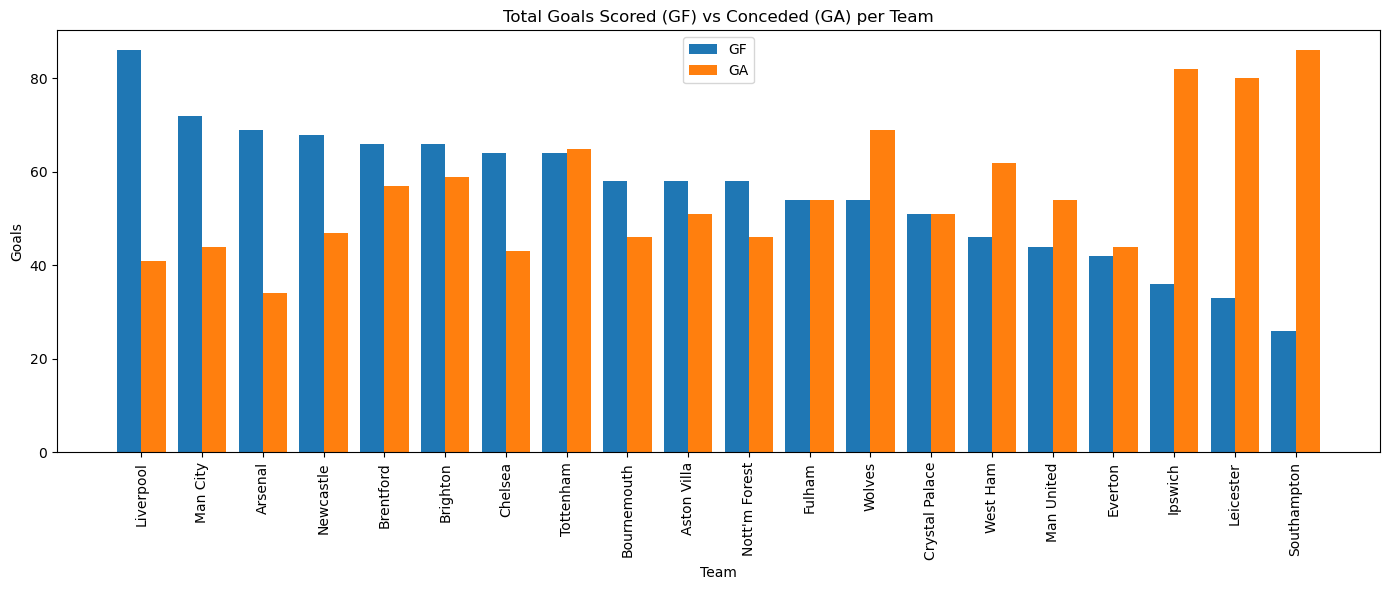

In [37]:
team_goals = (team_matches.groupby('Team')[['GF', 'GA']]
              .sum()
              .sort_values('GF', ascending=False))

x = range(len(team_goals))
width = 0.4

plt.figure(figsize=(14, 6))
plt.bar([i - width/2 for i in x], team_goals['GF'].values, width=0.4, label='GF')
plt.bar([i + width/2 for i in x], team_goals['GA'].values, width=0.4, label='GA')
plt.title('Total Goals Scored (GF) vs Conceded (GA) per Team')
plt.xlabel('Team')
plt.ylabel('Goals')
plt.xticks(ticks=x, labels=team_goals.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


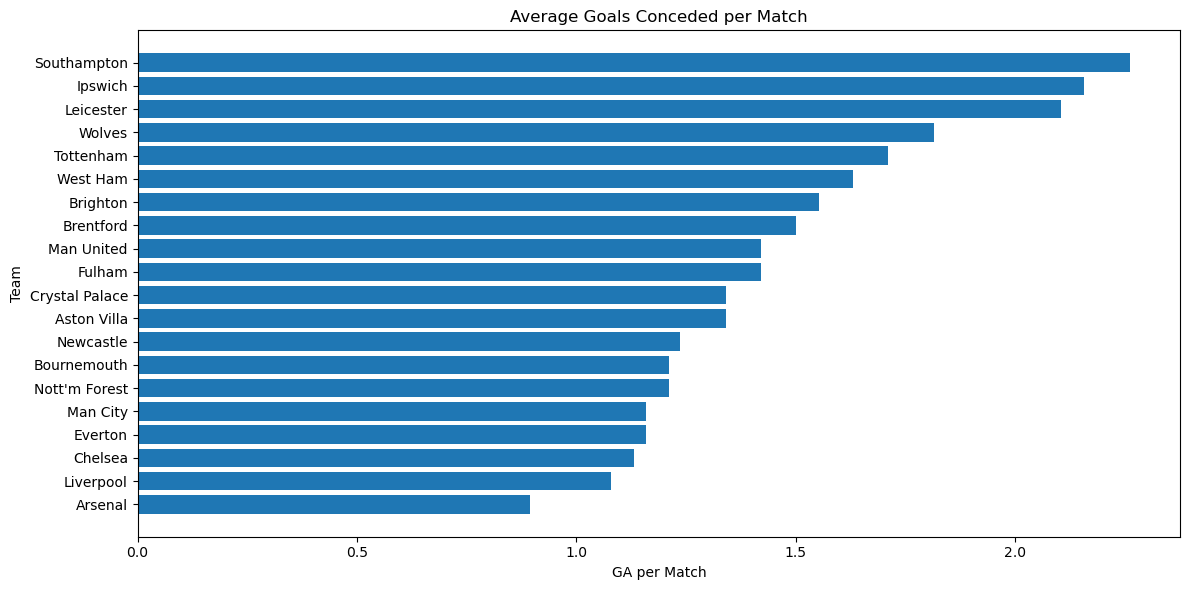

In [38]:
ga_per_match = (team_matches.groupby('Team')['GA']
                .mean()
                .sort_values(ascending=True))

plt.figure(figsize=(12, 6))
plt.barh(ga_per_match.index, ga_per_match.values)
plt.title('Average Goals Conceded per Match')
plt.xlabel('GA per Match')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


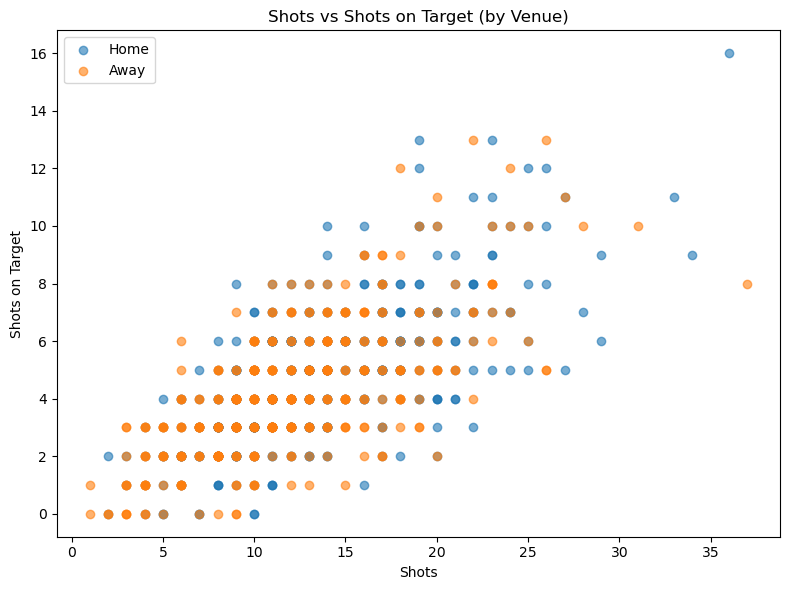

In [39]:
mask = team_matches['Shots'].notna() & team_matches['SOT'].notna()

plt.figure(figsize=(8, 6))
# Home
mh = mask & (team_matches['Venue'] == 'H')
plt.scatter(team_matches.loc[mh, 'Shots'], team_matches.loc[mh, 'SOT'], alpha=0.6, label='Home')
# Away
ma = mask & (team_matches['Venue'] == 'A')
plt.scatter(team_matches.loc[ma, 'Shots'], team_matches.loc[ma, 'SOT'], alpha=0.6, label='Away')

plt.title('Shots vs Shots on Target (by Venue)')
plt.xlabel('Shots')
plt.ylabel('Shots on Target')
plt.legend()
plt.tight_layout()
plt.show()


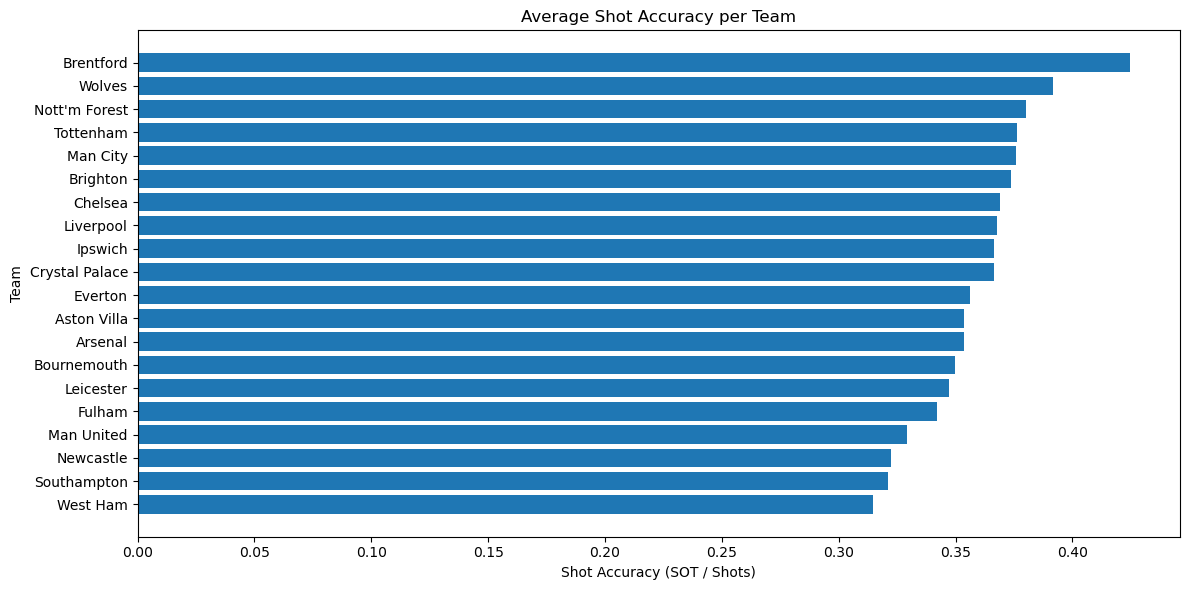

In [40]:
shot_acc = (team_matches.groupby('Team')['ShotAccuracy']
            .mean()
            .replace([np.inf, -np.inf], np.nan)
            .dropna()
            .sort_values(ascending=False))

plt.figure(figsize=(12, 6))
plt.barh(shot_acc.index, shot_acc.values)
plt.gca().invert_yaxis()
plt.title('Average Shot Accuracy per Team')
plt.xlabel('Shot Accuracy (SOT / Shots)')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


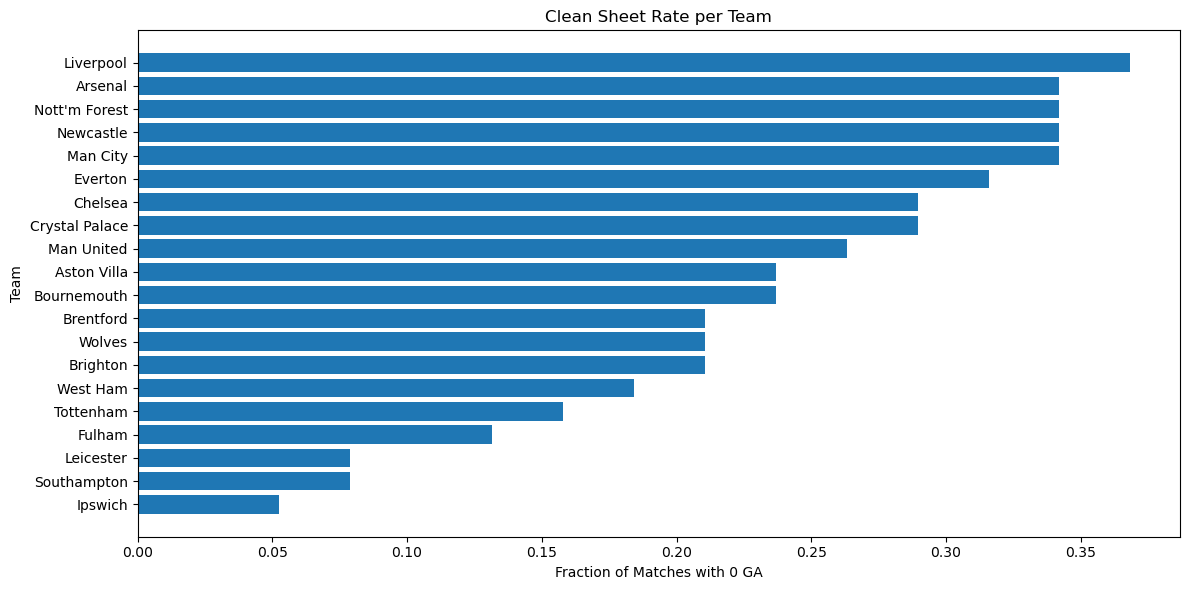

In [41]:
cs_rate = (team_matches.groupby('Team')['CleanSheet']
           .mean()
           .sort_values(ascending=False))

plt.figure(figsize=(12, 6))
plt.barh(cs_rate.index, cs_rate.values)
plt.gca().invert_yaxis()
plt.title('Clean Sheet Rate per Team')
plt.xlabel('Fraction of Matches with 0 GA')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


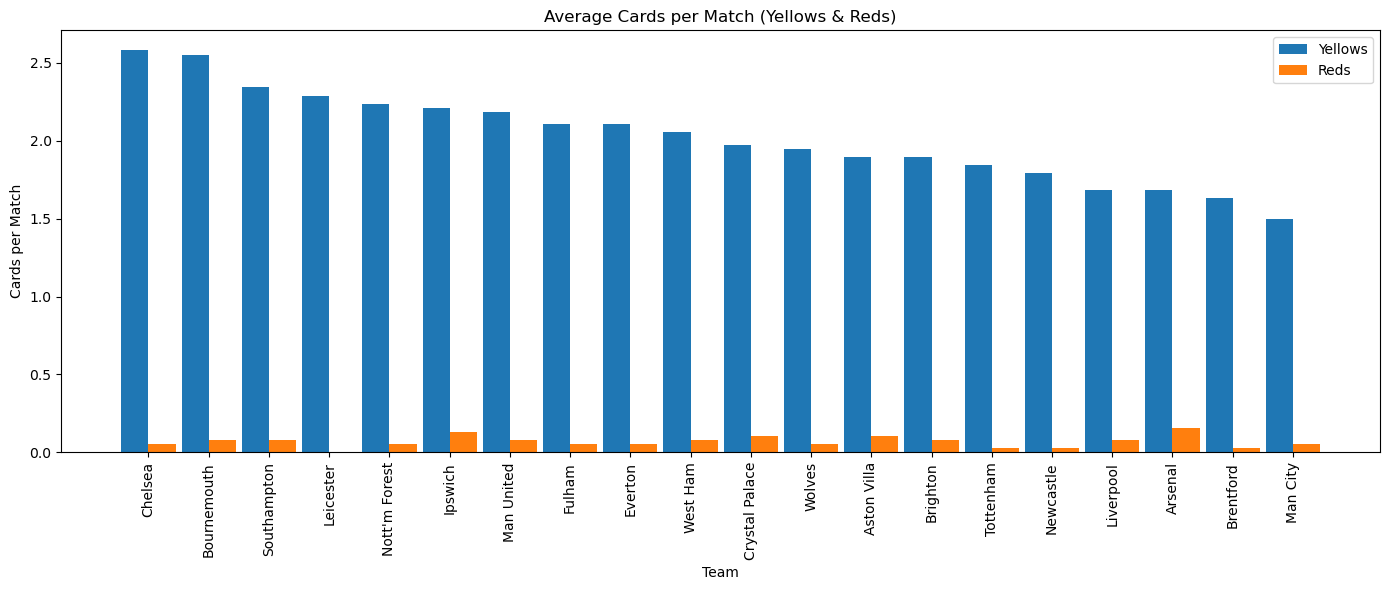

In [42]:
disc = (team_matches.groupby('Team')[['Yellows','Reds']]
        .mean()
        .sort_values('Yellows', ascending=False))

x = range(len(disc))
width = 0.45

plt.figure(figsize=(14, 6))
plt.bar([i - width/2 for i in x], disc['Yellows'].values, width=width, label='Yellows')
plt.bar([i + width/2 for i in x], disc['Reds'].values, width=width, label='Reds')
plt.title('Average Cards per Match (Yellows & Reds)')
plt.xlabel('Team')
plt.ylabel('Cards per Match')
plt.xticks(ticks=x, labels=disc.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


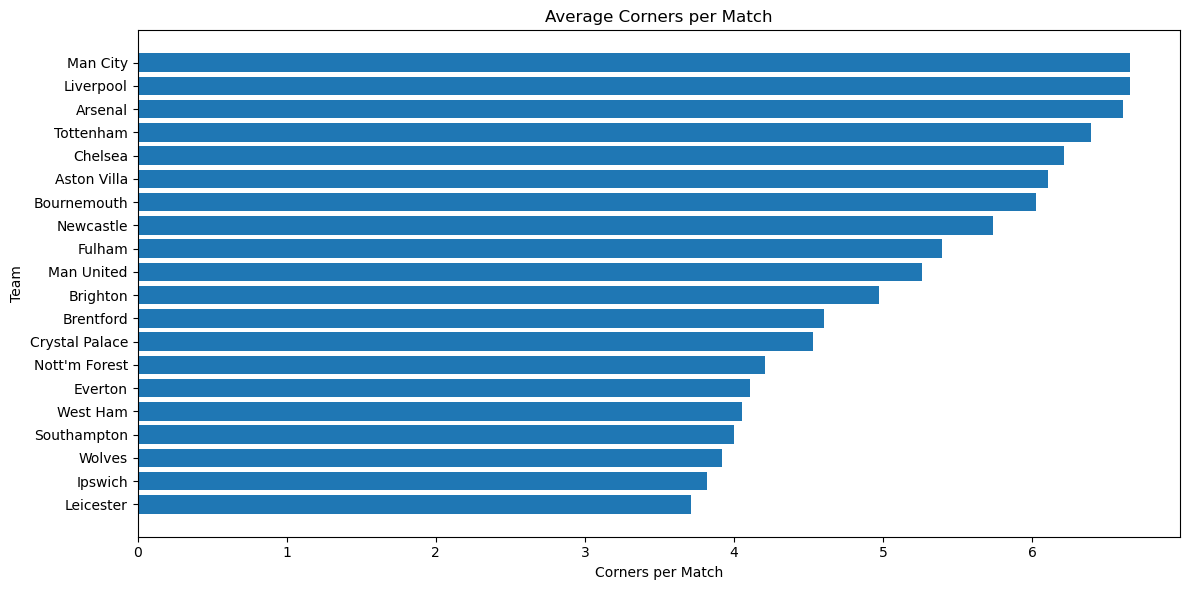

In [43]:
corners_pm = (team_matches.groupby('Team')['Corners']
              .mean()
              .sort_values(ascending=False))

plt.figure(figsize=(12, 6))
plt.barh(corners_pm.index, corners_pm.values)
plt.gca().invert_yaxis()
plt.title('Average Corners per Match')
plt.xlabel('Corners per Match')
plt.ylabel('Team')
plt.tight_layout()
plt.show()


In [44]:
TEAM = "Liverpool" # change Team name to select  a specific Premier League team

tm_team = team_matches[team_matches["Team"] == TEAM].copy()
assert not tm_team.empty, f"No rows found for team '{TEAM}'. Check exact name in your data."

tm_team = tm_team.sort_values("Date").reset_index(drop=True)

# Helpful extras
tm_team["Year"] = tm_team["Date"].dt.year
tm_team["Month"] = tm_team["Date"].dt.to_period("M").astype(str)  # e.g. '2025-08'
tm_team["GF"] = tm_team["GF"].astype("Float64")
tm_team["GA"] = tm_team["GA"].astype("Float64")
tm_team["Shots"] = tm_team["Shots"].astype("Float64")
tm_team["SOT"] = tm_team["SOT"].astype("Float64")
tm_team["ShotAccuracy"] = (tm_team["SOT"] / tm_team["Shots"]).where(tm_team["Shots"] > 0)
tm_team["Points"] = tm_team["Points"].astype("Float64")
tm_team["GD"] = tm_team["GF"] - tm_team["GA"]

print(TEAM, "matches:", len(tm_team))
tm_team.head(40)


Liverpool matches: 38


,League,Div,Date,Time,Team,Opponent,Venue,GF,GA,Shots,...,BookingsPts,Attendance,Referee,GD,Result,Points,CleanSheet,ShotAccuracy,Year,Month
0,E1,E0,2024-08-17,12:30:00,Liverpool,Ipswich,A,2.0,0.0,18.0,...,<NA>,<NA>,T Robinson,2.0,W,3.0,True,0.277778,2024,2024-08
1,E1,E0,2024-08-25,16:30:00,Liverpool,Brentford,H,2.0,0.0,19.0,...,<NA>,<NA>,S Attwell,2.0,W,3.0,True,0.421053,2024,2024-08
2,E1,E0,2024-09-01,16:00:00,Liverpool,Man United,A,3.0,0.0,11.0,...,<NA>,<NA>,A Taylor,3.0,W,3.0,True,0.272727,2024,2024-09
3,E1,E0,2024-09-14,15:00:00,Liverpool,Nott'm Forest,H,0.0,1.0,14.0,...,<NA>,<NA>,M Oliver,-1.0,L,0.0,False,0.357143,2024,2024-09
4,E1,E0,2024-09-21,15:00:00,Liverpool,Bournemouth,H,3.0,0.0,19.0,...,<NA>,<NA>,T Harrington,3.0,W,3.0,True,0.684211,2024,2024-09
5,E1,E0,2024-09-28,17:30:00,Liverpool,Wolves,A,2.0,1.0,10.0,...,<NA>,<NA>,A Taylor,1.0,W,3.0,False,0.6,2024,2024-09
6,E1,E0,2024-10-05,12:30:00,Liverpool,Crystal Palace,A,1.0,0.0,16.0,...,<NA>,<NA>,S Hooper,1.0,W,3.0,True,0.25,2024,2024-10
7,E1,E0,2024-10-20,16:30:00,Liverpool,Chelsea,H,2.0,1.0,9.0,...,<NA>,<NA>,J Brooks,1.0,W,3.0,False,0.555556,2024,2024-10
8,E1,E0,2024-10-27,16:30:00,Liverpool,Arsenal,A,2.0,2.0,9.0,...,<NA>,<NA>,A Taylor,0.0,D,1.0,False,0.444444,2024,2024-10
9,E1,E0,2024-11-02,15:00:00,Liverpool,Brighton,H,2.0,1.0,16.0,...,<NA>,<NA>,T Harrington,1.0,W,3.0,False,0.5,2024,2024-11


Liverpool — Matches: 38, W-D-L: 25-9-4
Goals: GF = 86.0 GA = 41.0 GD = 45.0
Points: 84.0  | Pts/Match: 2.210526315789474

Results by Venue:
 Result  D  L   W
Venue           
A       5  3  11
H       4  1  14


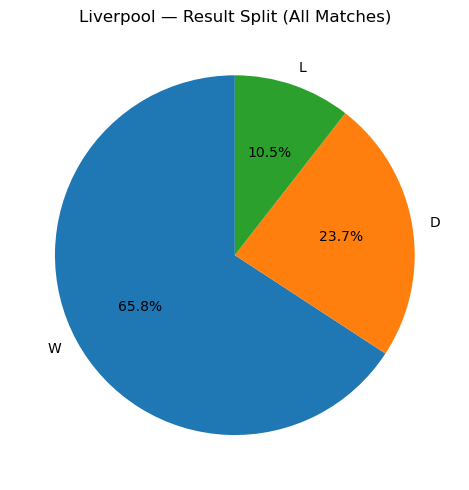

In [45]:
# Overall record
total_matches = len(tm_team)
wins = (tm_team["Result"] == "W").sum()
draws = (tm_team["Result"] == "D").sum()
losses = (tm_team["Result"] == "L").sum()

print(f"{TEAM} — Matches: {total_matches}, W-D-L: {wins}-{draws}-{losses}")
print("Goals: GF =", tm_team["GF"].sum(), "GA =", tm_team["GA"].sum(), "GD =", (tm_team["GF"].sum() - tm_team["GA"].sum()))
print("Points:", tm_team["Points"].sum(), " | Pts/Match:", tm_team["Points"].mean())

# Venue splits
venue_counts = tm_team.groupby("Venue")["Result"].value_counts().unstack(fill_value=0)
print("\nResults by Venue:\n", venue_counts)

# Plot W/D/L proportion overall
labels = ["W","D","L"]
vals = [wins, draws, losses]

plt.figure(figsize=(5,5))
plt.pie(vals, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title(f"{TEAM} — Result Split (All Matches)")
plt.tight_layout()
plt.show()


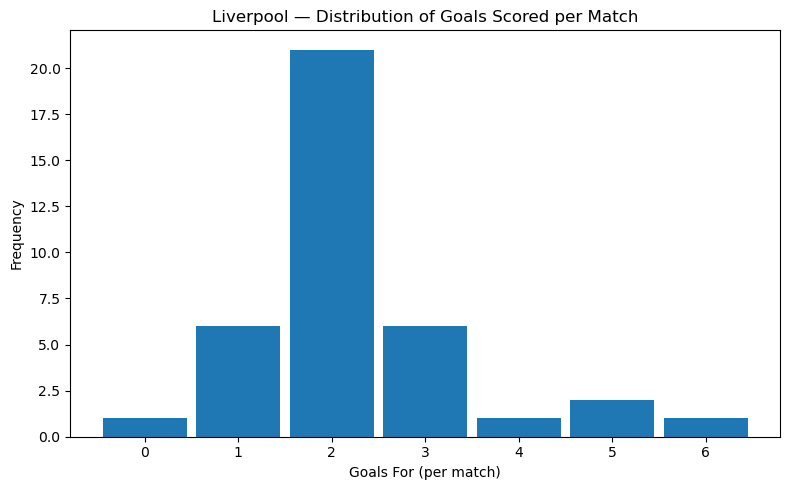

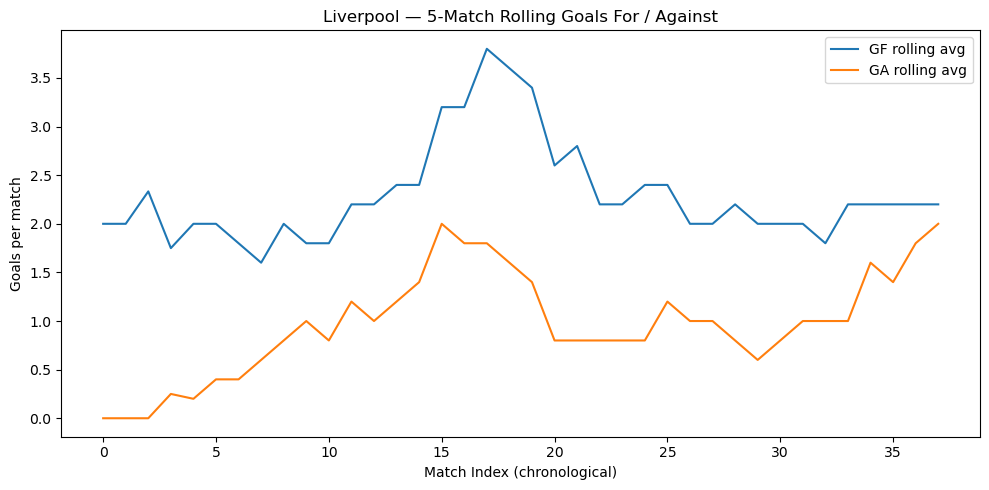

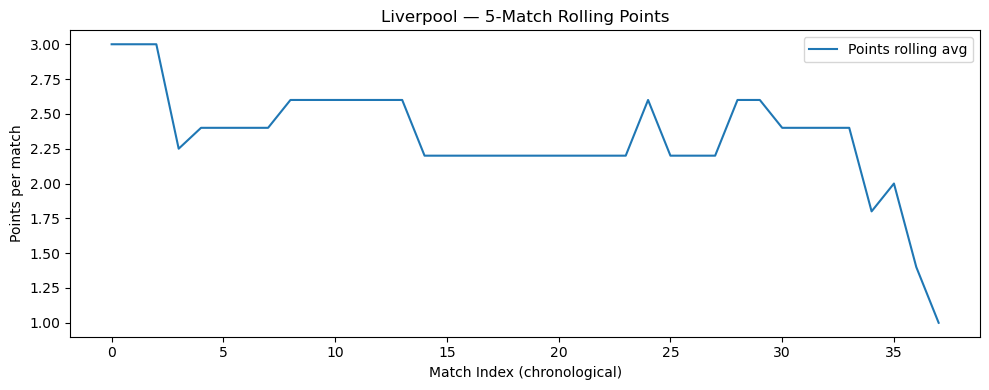

In [46]:
# Distribution
goals = tm_team["GF"].fillna(0).values
plt.figure(figsize=(8,5))
bins = np.arange(0, np.nanmax(goals)+2) - 0.5  # center bins on integers
plt.hist(goals, bins=bins, rwidth=0.9)
plt.xticks(range(int(np.nanmax(goals))+1))
plt.title(f"{TEAM} — Distribution of Goals Scored per Match")
plt.xlabel("Goals For (per match)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Rolling trends (sorted by date)
tm_team_sorted = tm_team.sort_values("Date").reset_index(drop=True)
window = 5  # tweak as you like
roll_GF = tm_team_sorted["GF"].rolling(window, min_periods=1).mean()
roll_GA = tm_team_sorted["GA"].rolling(window, min_periods=1).mean()
roll_Pts = tm_team_sorted["Points"].rolling(window, min_periods=1).mean()

plt.figure(figsize=(10,5))
plt.plot(roll_GF.index, roll_GF.values, label="GF rolling avg")
plt.plot(roll_GA.index, roll_GA.values, label="GA rolling avg")
plt.title(f"{TEAM} — {window}-Match Rolling Goals For / Against")
plt.xlabel("Match Index (chronological)")
plt.ylabel("Goals per match")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(roll_Pts.index, roll_Pts.values, label="Points rolling avg")
plt.title(f"{TEAM} — {window}-Match Rolling Points")
plt.xlabel("Match Index (chronological)")
plt.ylabel("Points per match")
plt.legend()
plt.tight_layout()
plt.show()


Liverpool — Shots: 648.0, SOT: 231.0, Shot Accuracy: 0.356
Goals per Shot: 0.133
Goals per SOT: 0.372


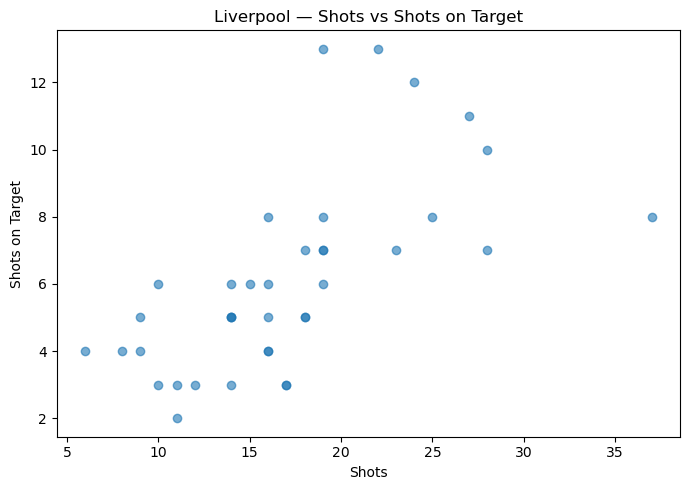

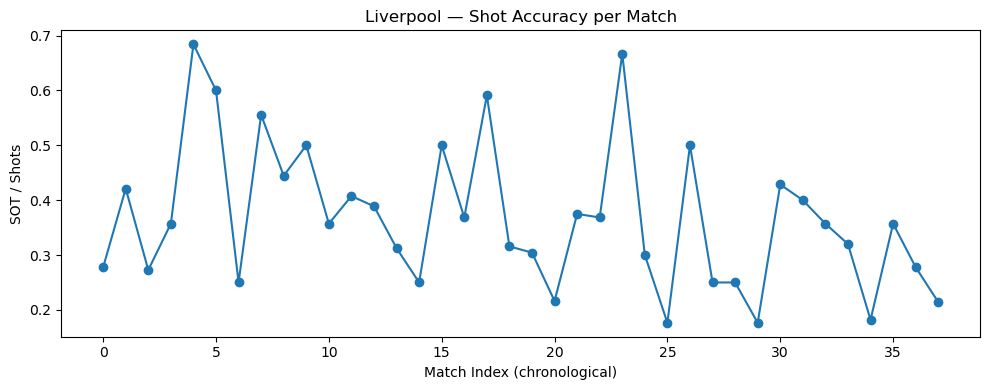

In [47]:
# Aggregates
shots = tm_team["Shots"].sum(skipna=True)
sot = tm_team["SOT"].sum(skipna=True)
gf = tm_team["GF"].sum(skipna=True)
acc = (sot / shots) if (shots and shots > 0) else np.nan
gps = (gf / shots) if (shots and shots > 0) else np.nan
gpsot = (gf / sot) if (sot and sot > 0) else np.nan

print(f"{TEAM} — Shots: {shots}, SOT: {sot}, Shot Accuracy: {acc:.3f}" if pd.notna(acc) else f"{TEAM} — Shot Accuracy: NA")
print(f"Goals per Shot: {gps:.3f}" if pd.notna(gps) else "Goals per Shot: NA")
print(f"Goals per SOT: {gpsot:.3f}" if pd.notna(gpsot) else "Goals per SOT: NA")

# Scatter: Shots vs SOT with trend of GF
mask = tm_team["Shots"].notna() & tm_team["SOT"].notna()

plt.figure(figsize=(7,5))
plt.scatter(tm_team.loc[mask, "Shots"], tm_team.loc[mask, "SOT"], alpha=0.6)
plt.title(f"{TEAM} — Shots vs Shots on Target")
plt.xlabel("Shots")
plt.ylabel("Shots on Target")
plt.tight_layout()
plt.show()

# Shot accuracy per match (line)
plt.figure(figsize=(10,4))
plt.plot(tm_team_sorted.index, tm_team_sorted["ShotAccuracy"], marker='o', linestyle='-')
plt.title(f"{TEAM} — Shot Accuracy per Match")
plt.xlabel("Match Index (chronological)")
plt.ylabel("SOT / Shots")
plt.tight_layout()
plt.show()


Liverpool — GA per Match: 1.079, Clean Sheet Rate: 0.368


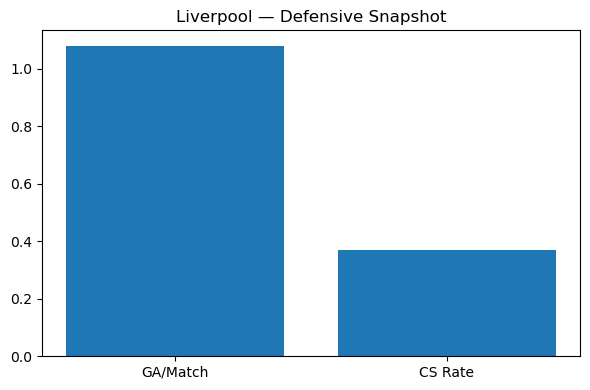

In [48]:
ga_pm = tm_team["GA"].mean()
cs_rate = tm_team["GA"].eq(0).mean()

print(f"{TEAM} — GA per Match: {ga_pm:.3f}, Clean Sheet Rate: {cs_rate:.3f}")

# Bars: GA per match vs Clean sheet rate
plt.figure(figsize=(6,4))
plt.bar(["GA/Match","CS Rate"], [ga_pm, cs_rate])
plt.title(f"{TEAM} — Defensive Snapshot")
plt.tight_layout()
plt.show()


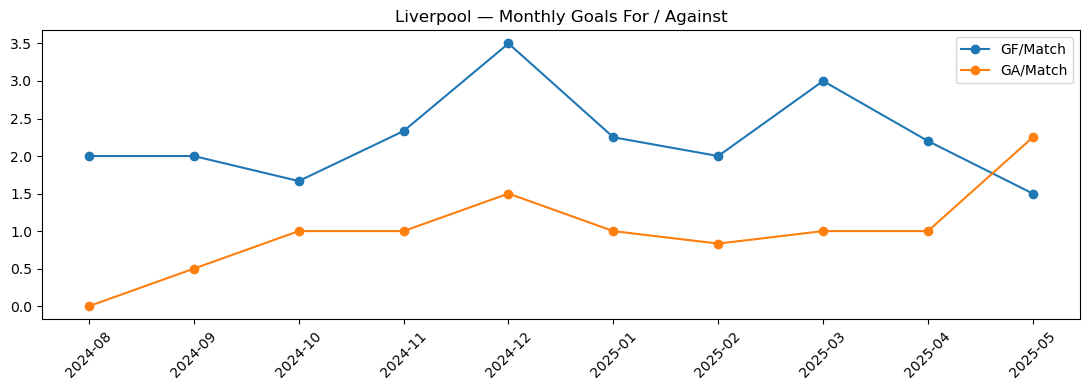

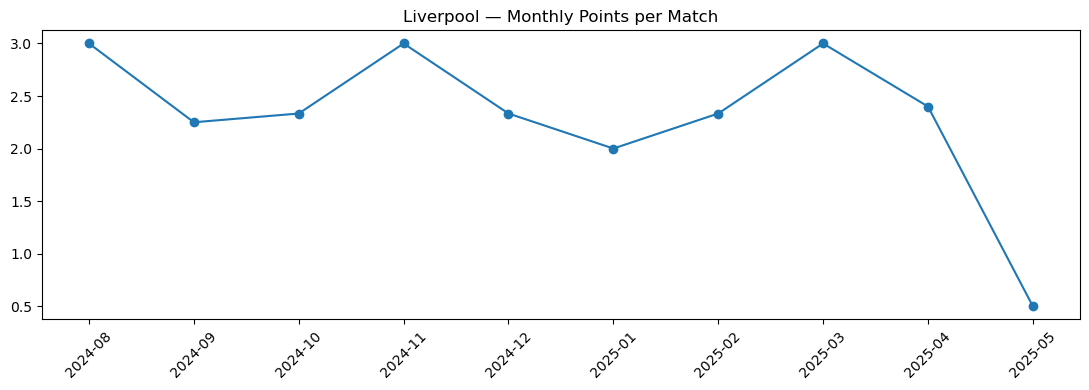

In [49]:
monthly = (tm_team.groupby("Month", as_index=False)
           .agg(
               Matches=("Team","size"),
               GF=("GF","mean"),
               GA=("GA","mean"),
               Pts=("Points","mean"),
           ))

# Keep chronological order by converting Month back to period for sorting
monthly["_order"] = pd.PeriodIndex(monthly["Month"], freq="M")
monthly = monthly.sort_values("_order")

plt.figure(figsize=(11,4))
plt.plot(monthly["_order"].astype(str), monthly["GF"], marker="o", label="GF/Match")
plt.plot(monthly["_order"].astype(str), monthly["GA"], marker="o", label="GA/Match")
plt.xticks(rotation=45)
plt.title(f"{TEAM} — Monthly Goals For / Against")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(11,4))
plt.plot(monthly["_order"].astype(str), monthly["Pts"], marker="o")
plt.xticks(rotation=45)
plt.title(f"{TEAM} — Monthly Points per Match")
plt.tight_layout()
plt.show()


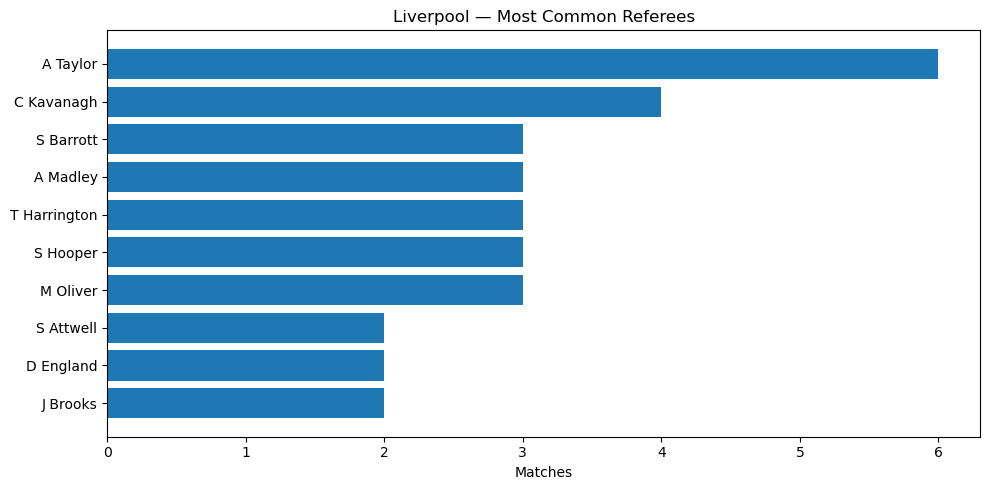

In [50]:
ref_tbl = (tm_team.dropna(subset=["Referee"])
           .groupby("Referee", as_index=False)
           .agg(
               Matches=("Referee","size"),
               PtsPerMatch=("Points","mean"),
               AvgYellows=("Yellows","mean"),
               AvgReds=("Reds","mean"),
               AvgFouls=("Fouls","mean"),
           )
           .sort_values(["Matches","PtsPerMatch"], ascending=[False,False])
          )

ref_tbl.head(15)

top = ref_tbl.head(10)
plt.figure(figsize=(10,5))
plt.barh(top["Referee"], top["Matches"])
plt.gca().invert_yaxis()
plt.title(f"{TEAM} — Most Common Referees")
plt.xlabel("Matches")
plt.tight_layout()
plt.show()



Aston Villa — Home vs Away summary


,Matches,Wins,Draws,Losses,GF,GA,Points,GD,PtsPerMatch,GF_per_match,GA_per_match
Venue,,,,,,,,,,,
A,19,8,2,9,24,31,26,-7,1.368421,1.263158,1.631579
H,19,11,7,1,34,20,40,14,2.105263,1.789474,1.052632


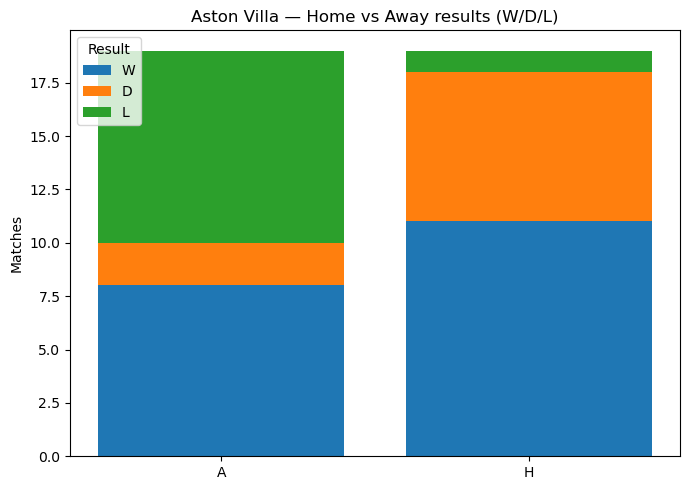

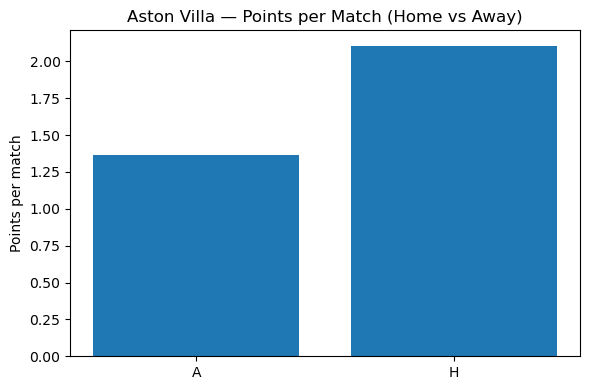

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def plot_home_away_form(team_name: str):
    """
    Show home vs away form for a given team.
    Requires `team_matches` to already be defined.
    """
    tm = team_matches[team_matches["Team"] == team_name].copy()
    if tm.empty:
        raise ValueError(f"No rows found for team '{team_name}'. "
                         "Check the exact name in team_matches['Team'].")

    # Make sure numeric columns are numeric
    for col in ["GF", "GA", "Points"]:
        tm[col] = pd.to_numeric(tm[col], errors="coerce")

    # ---- Summary table by venue ----
    summary = (
        tm.groupby("Venue")
          .agg(
              Matches = ("Team", "size"),
              Wins    = ("Result", lambda s: (s == "W").sum()),
              Draws   = ("Result", lambda s: (s == "D").sum()),
              Losses  = ("Result", lambda s: (s == "L").sum()),
              GF      = ("GF", "sum"),
              GA      = ("GA", "sum"),
              Points  = ("Points", "sum"),
          )
    )

    summary["GD"]           = summary["GF"] - summary["GA"]
    summary["PtsPerMatch"]  = summary["Points"] / summary["Matches"]
    summary["GF_per_match"] = summary["GF"] / summary["Matches"]
    summary["GA_per_match"] = summary["GA"] / summary["Matches"]

    print(f"\n{team_name} — Home vs Away summary")
    try:
        display(summary)  # works in Jupyter
    except NameError:
        print(summary)

    # ---- 1) Stacked bar: W/D/L by venue ----
    wdl = (
        tm.groupby(["Venue", "Result"])
          .size()
          .unstack(fill_value=0)[["W", "D", "L"]]
    )

    venues = wdl.index.tolist()   # typically ['H', 'A']
    x = np.arange(len(venues))

    plt.figure(figsize=(7, 5))
    bottom = np.zeros(len(venues))
    for res_label in ["W", "D", "L"]:
        vals = wdl[res_label].values
        plt.bar(x, vals, bottom=bottom, label=res_label)
        bottom += vals

    plt.xticks(x, venues)
    plt.ylabel("Matches")
    plt.title(f"{team_name} — Home vs Away results (W/D/L)")
    plt.legend(title="Result")
    plt.tight_layout()
    plt.show()

    # ---- 2) Bar plot: points per match home vs away ----
    plt.figure(figsize=(6, 4))
    plt.bar(summary.index, summary["PtsPerMatch"])
    plt.ylabel("Points per match")
    plt.title(f"{team_name} — Points per Match (Home vs Away)")
    plt.tight_layout()
    plt.show()
plot_home_away_form("Aston Villa")
